In [1]:
from datetime import datetime
from io import BytesIO
import numpy as np
import requests
from PIL import Image
from random import (
    choice,
    randint,
)

IDR = 'idr.openmicroscopy.org'


def get(p):
    # Due to caching absolute API UIRLs in API responses may be http or https
    if not p.startswith('https://' + IDR) and not p.startswith('http://' + IDR):
        p = 'https://' + IDR + p
    r = requests.get(p)
    r.raise_for_status()
    return r


def api(p):
    return get(p).json()


PROJECTS = api('/api/v0/m/projects/')
SCREENS = api('/api/v0/m/screens/')


def image_thumb(iid, stretchint, w, h):
    quantiles = [0.02, 0.5, 0.98]
    minintensity = 26
    # 256/256 resizes the image (if rectangular it'll be distorted)
    i = get('/webgateway/render_thumbnail/{}/{}/{}'.format(iid, w, h))
    # jpegs:[0,255]
    s = BytesIO(i.content)
    # https://stackoverflow.com/a/44606972
    px = Image.open(s)
    # display(px)
    arr = np.array(px)
    cs = arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2])
    qs = np.quantile(cs, quantiles, 0)
    if (qs[1, :] < minintensity).all():
        # display('Intensity too low: {}'.format(qs[1, :]))
        return None
    else:
        if stretchint:
            for c in range(arr.shape[2]):
                # Only normalise if not just low-level noise
                if qs[1, c] >= minintensity:
                    arr[:, :, c] = (arr[:, :, c] - qs[0, c]) / qs[2, c] * 256
            return Image.fromarray(arr)
        return px


class NoChildren(Exception):
    def __init__(self, msg):
        super(Exception, self).__init__(msg)


def get_random_obj(parent, childtype):
    children = api(parent['url:' + childtype])
    count = children['meta']['totalCount']
    if not count:
        raise NoChildren(childtype)
    return children['data'][randint(0, min(count, children['meta']['limit']) - 1)]


def get_project_im(pidx):
    p = PROJECTS['data'][pidx]
    d = get_random_obj(p, 'datasets')
    im = get_random_obj(d, 'images')
    return im


def get_screen_im(sidx):
    s = SCREENS['data'][sidx]
    p = get_random_obj(s, 'plates')
    w = get_random_obj(p, 'wells')
    try:
        wsample = choice(w['WellSamples'])
    except KeyError:
        raise NoChildren('WellSamples')
    return wsample['Image']


def get_random_image(iids, thumbwidth, thumbheight):
    p_or_s = randint(0, PROJECTS['meta']['totalCount'] + SCREENS['meta']['totalCount'] - 1)
    if p_or_s < PROJECTS['meta']['totalCount']:
        im = get_project_im(p_or_s)
    else:
        im = get_screen_im(p_or_s - PROJECTS['meta']['totalCount'])
    iid = im['@id']

    print('Loading Image:{}'.format(iid))
    if iid in iids:
        print('  Ignoring: Already used')
        return None
    iids.add(iid)
    impx = image_thumb(iid, False, thumbwidth, thumbheight)
    if not impx:
        print('  Ignoring: Low intensity')
        return None
    return impx


Loading Image:928862
Loading Image:3491153
Loading Image:3491548
  Ignoring: Low intensity
Loading Image:4495405
Loading Image:3210534
  Ignoring: Low intensity
Loading Image:5514044
Loading Image:4994068
  Ignoring: Low intensity
Loading Image:273164
  Ignoring: Low intensity
Loading Image:6007185
Loading Image:5514079
Loading Image:1884870
  Ignoring: Low intensity
Loading Image:5514038
Loading Image:4496893
  Ignoring: Low intensity
Loading Image:1811833
Loading Image:3178647
Loading Image:3414072
  Ignoring: Low intensity
Loading Image:842917
Loading Image:5514036
Loading Image:197670
Loading Image:3235484
  Ignoring: Low intensity
Loading Image:696866
  Ignoring: Low intensity
Loading Image:1522433
  Ignoring: Low intensity
Loading Image:2029560
  Ignoring: Low intensity
Loading Image:3072167
  Ignoring: Low intensity
Loading Image:2882159
  Ignoring: Low intensity
Loading Image:3414026
  Ignoring: Low intensity
Loading Image:4007821
  Ignoring: Low intensity
Loading Image:3191918

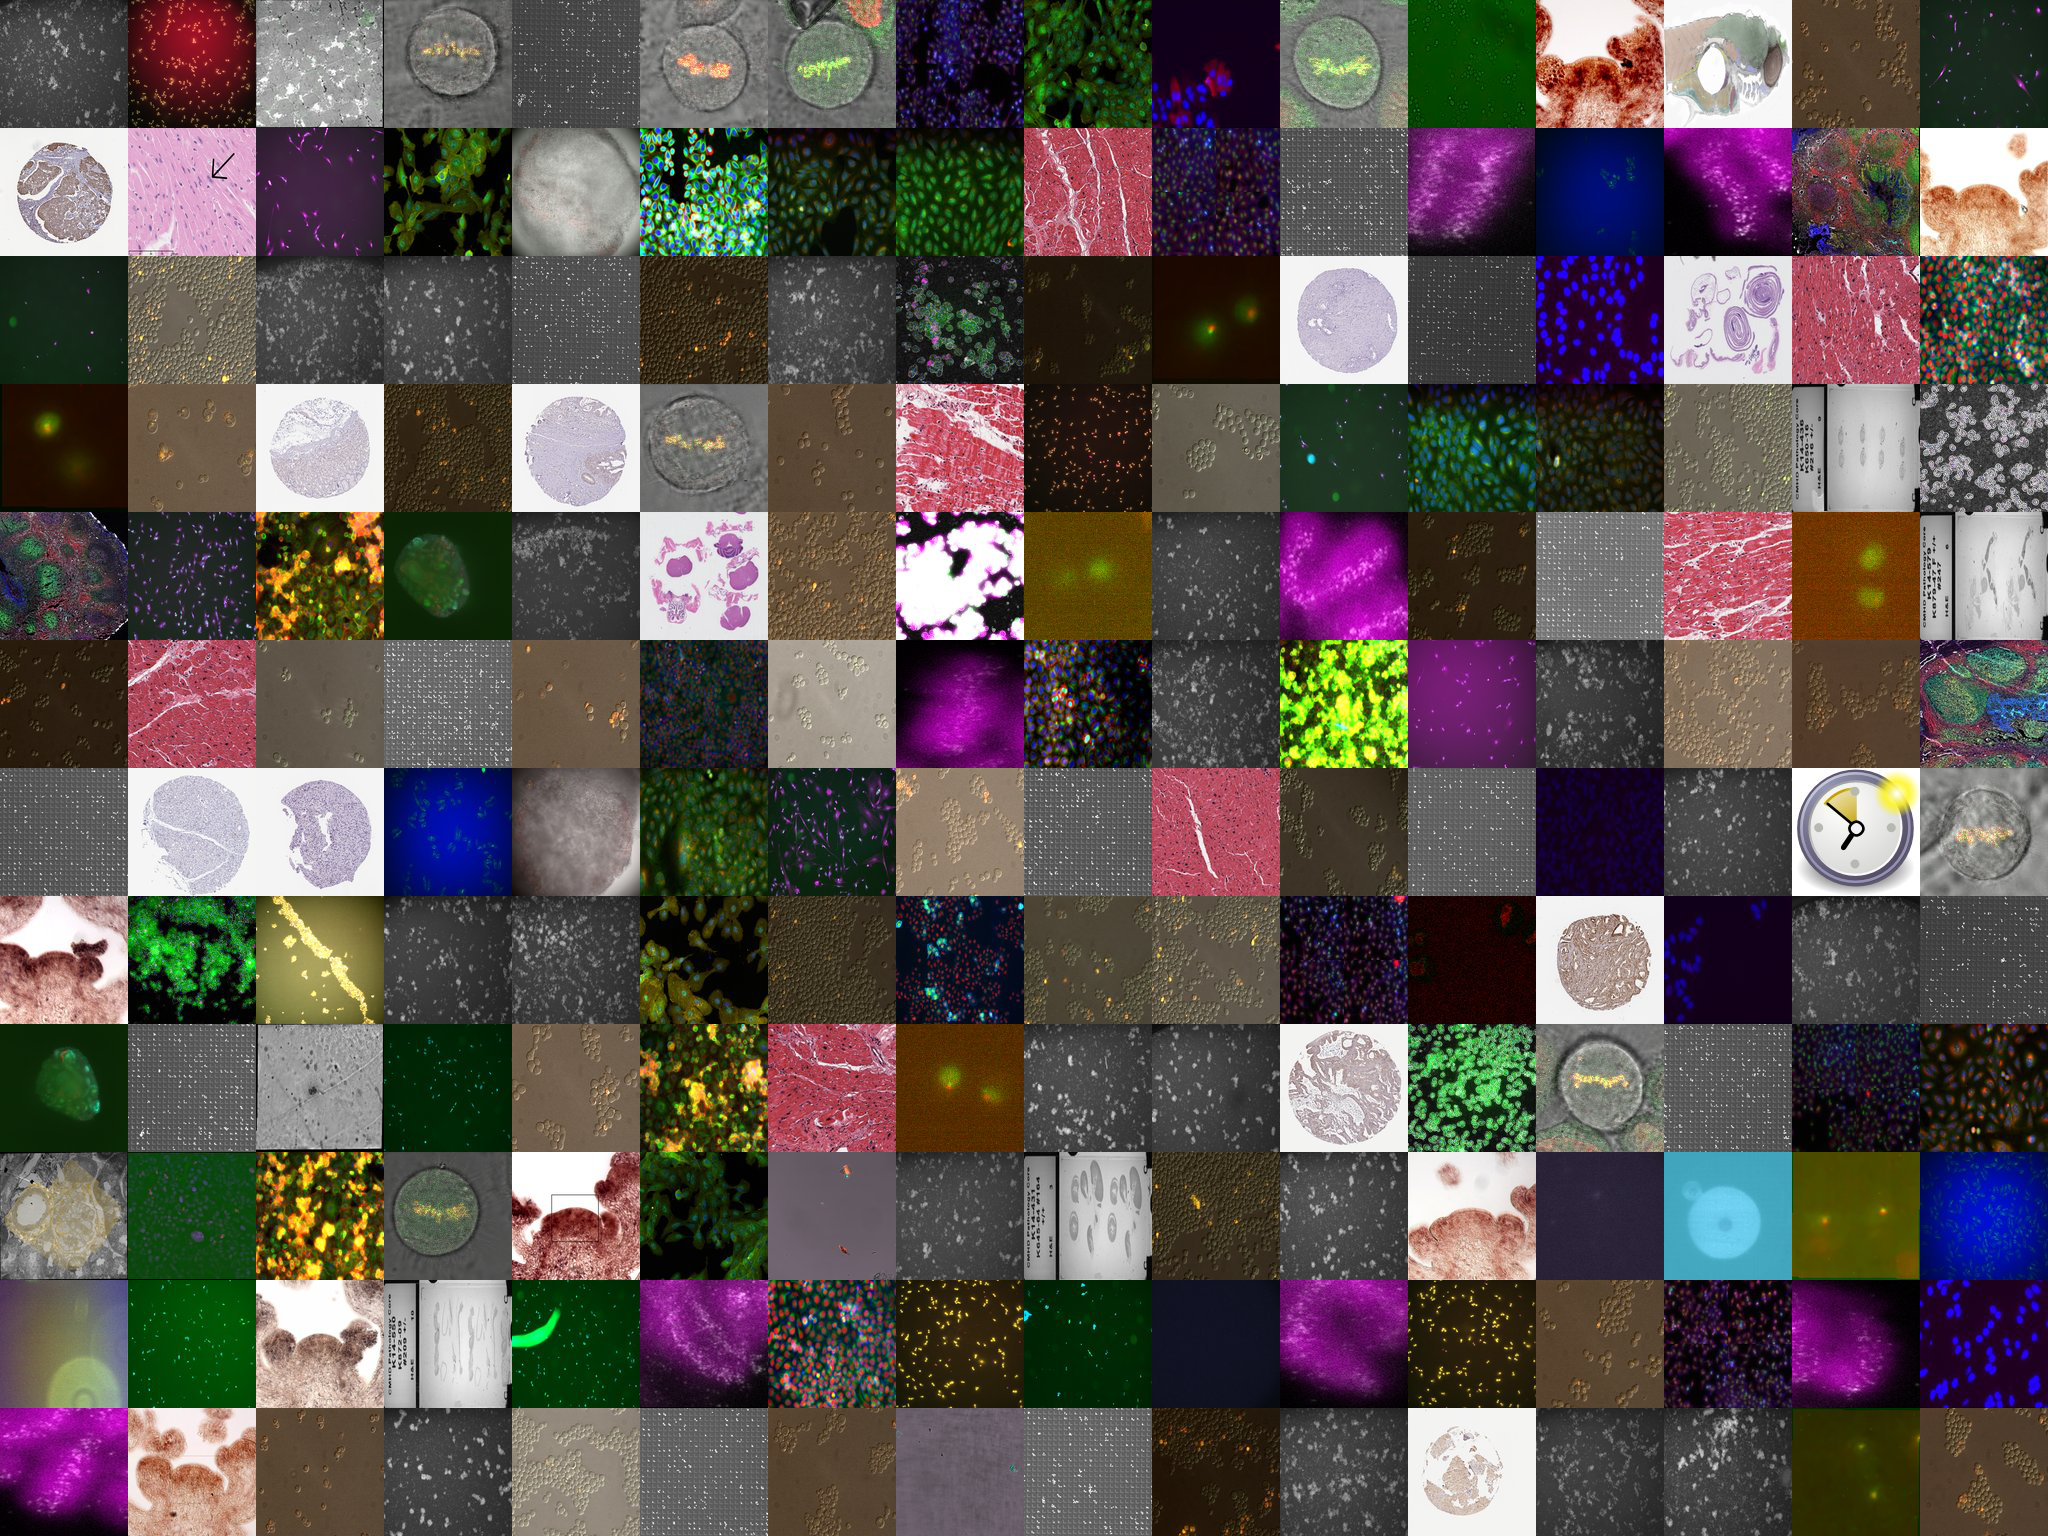

In [3]:
nrows = 12
ncols = 16
wh = 128
montagerows = []
used = set()


# Bug in render_thumbnail, may return a different size?
def montage_pad(a, expected):
    if a.shape != expected:
        print('  Unexpected shape: {}'.format(a.shape))
        a = np.pad(a, [(0, expected[0] - a.shape[0]), (0, expected[1] - a.shape[1]), (0, expected[2] - a.shape[2])], 'constant')
    return a


for r in range(nrows):
    montagecols = []
    for c in range(ncols):
        impx = None
        while not impx:
            try:
                impx = get_random_image(used, wh, wh)
            except NoChildren:
                pass
            except requests.HTTPError as e:
                print(e)
        a = montage_pad(np.array(impx), (wh, wh, 3))
        montagecols.append(a)
    montagerows.append(np.hstack(montagecols))

montage = Image.fromarray(np.vstack(montagerows))
display(montage)
montage.save('montage-{}.jpg'.format(str(datetime.utcnow())[:19].replace('-', '').replace(':', '').replace(' ', 'T')))